In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scoobscc.math_module import xp, xcipy, ensure_np_array
from scoobscc.imshows import imshow1, imshow2, imshow3
from scoobscc import utils
from scoobscc import dm
import scoobscc.scoob_model as scoobm

wfe_data = utils.load_pickle('/home/derbyk/src/scoob-scc/data_sim/example_wfe_data.pkl')

/home/derbyk/miniconda3/envs/py310-stp-env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
/home/derbyk/miniconda3/envs/py310-stp-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-19 13:48:04,774	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


SCoOB interface does not have the required packages to operate.


Oversampling > 2x suggested for reliable results in Fresnel propagation.


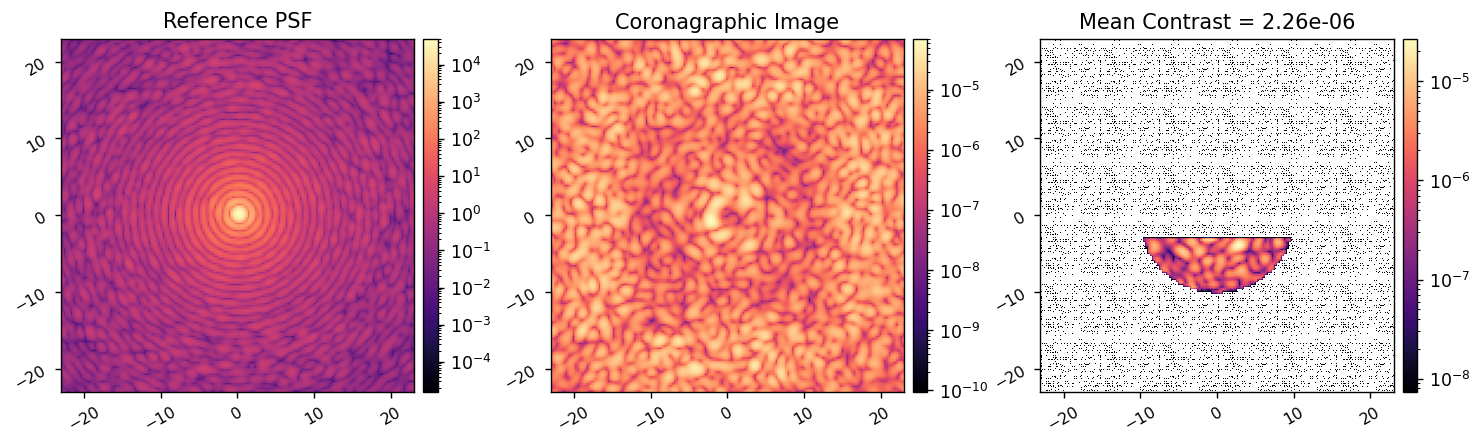

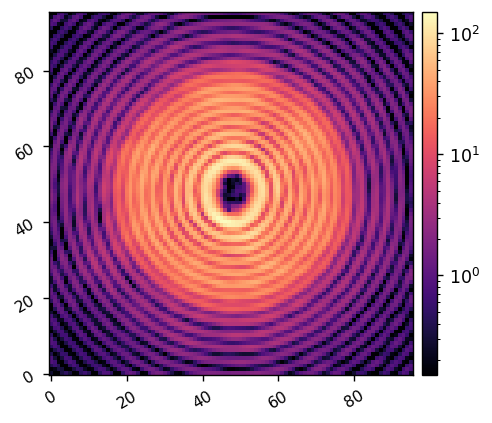

In [2]:
reload(scoobm)
reload(utils)

M = scoobm.single(
    dm_ref=wfe_data['DM_FLAT'],
)
M.PREFPM_AMP = wfe_data['PREFPM_AMP']
M.PREFPM_OPD = wfe_data['PREFPM_OPD']

M.POSTFPM_AMP = wfe_data['POSTFPM_AMP']
M.POSTFPM_OPD = wfe_data['POSTFPM_OPD']

M.RLS_AMP = wfe_data['RLS_AMP']
M.RLS_OPD = wfe_data['RLS_OPD']

# M.ncamsci = 256
# M.ncamlo = 96
# M.llowfsc_defocus = 2.75e-3

iwa = 3
owa = 10
control_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)

M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast = xp.mean(camsci_im0[control_mask])

imshow3(
    ref_psf, camsci_im0, camsci_im0*control_mask,
    'Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast:.2e}', 
    pxscl=M.camsci_pxscl_lamDc,
    lognorm=1, 
)

camlo_im0 = M.snap_camlo()
imshow1(camlo_im0, lognorm=1, vmin=xp.max(camlo_im0)/1e3)

In [3]:
reload(utils)
M.plot_oversample = 2.048
M.reset_dm()

waffle_command = 10e-9 * dm.make_fourier_command(x_cpa=17, y_cpa=17, Nact=M.Nact)
M.add_dm(waffle_command)

M.use_vortex = 1

# E_EP, DM_PHASOR, E_DM, E_LP, E_LS, E_CAMSCI = M.calc_wfs_camsci(return_all=True)
titles = ['EP WF', 'DM', 'Post-DM WF', 'Pre-Lyot WF', 'Post-Lyot WF', 'Camsci WF']
Efields = M.calc_wfs_camsci(return_all=True)

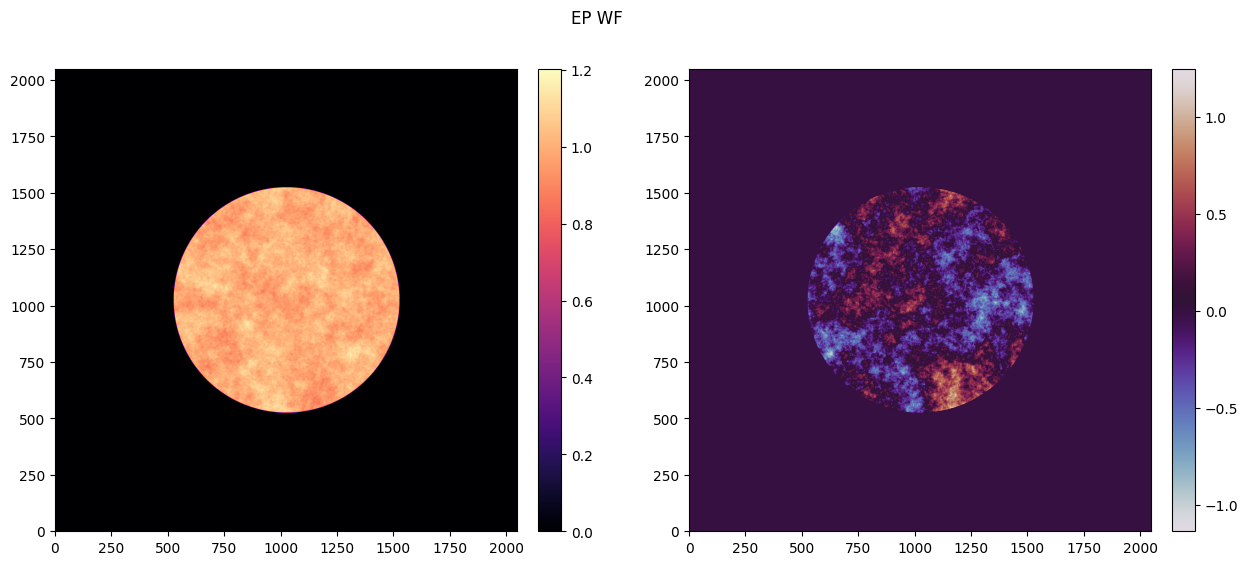

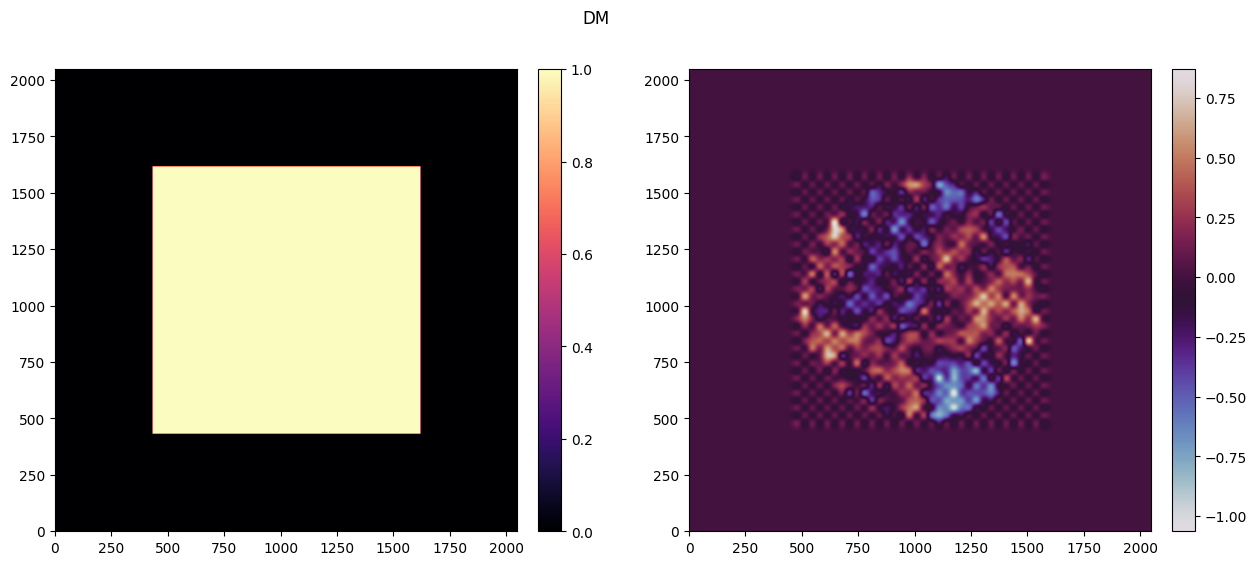

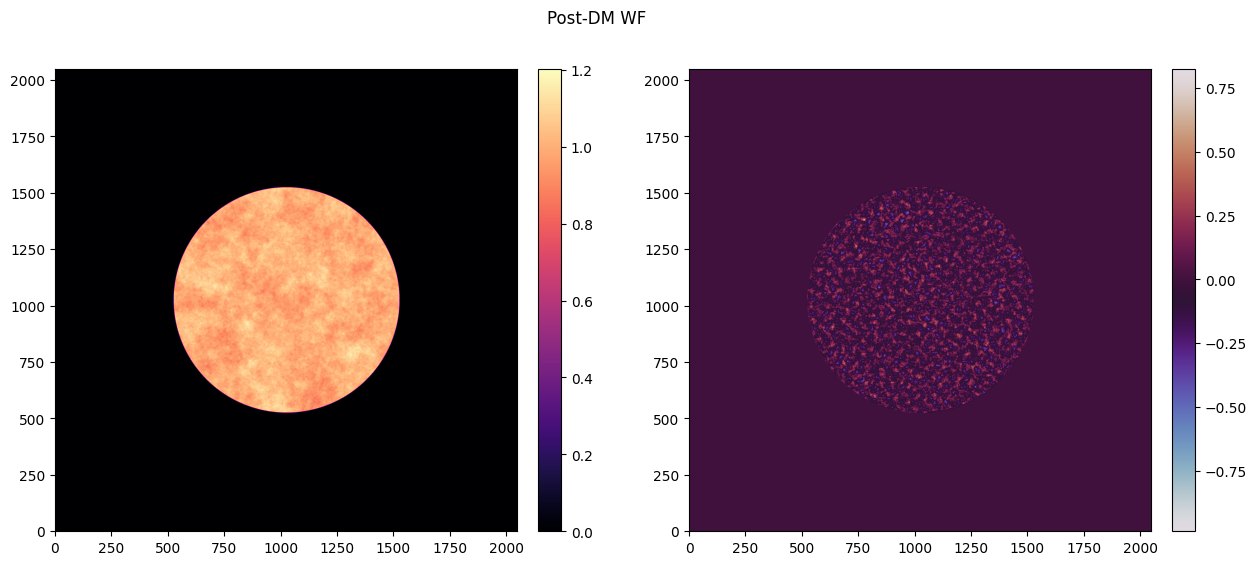

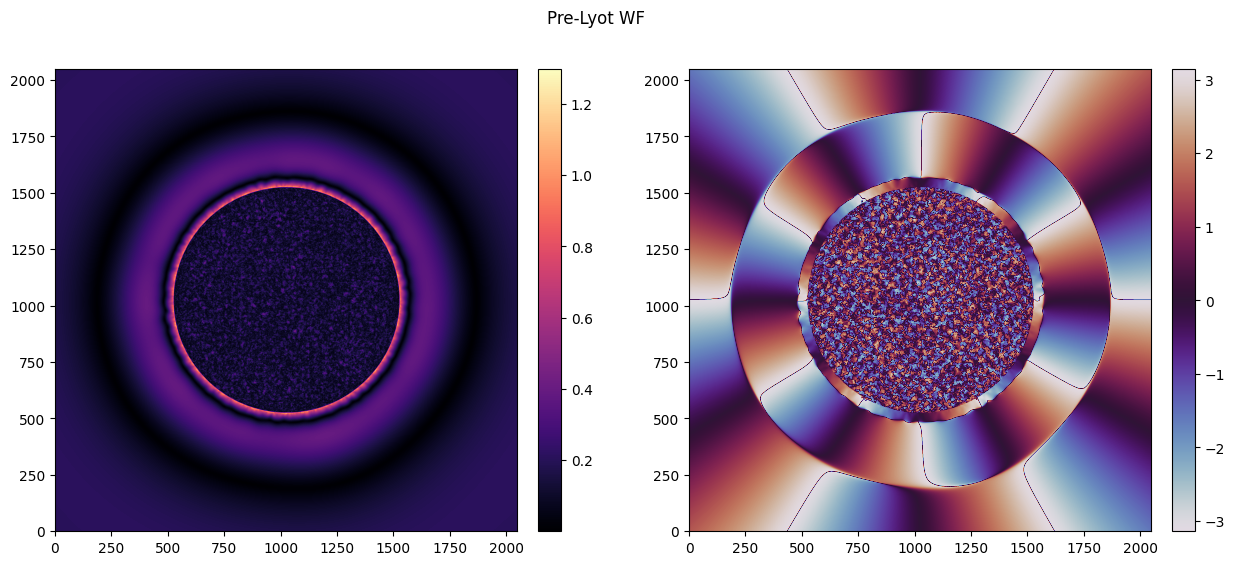

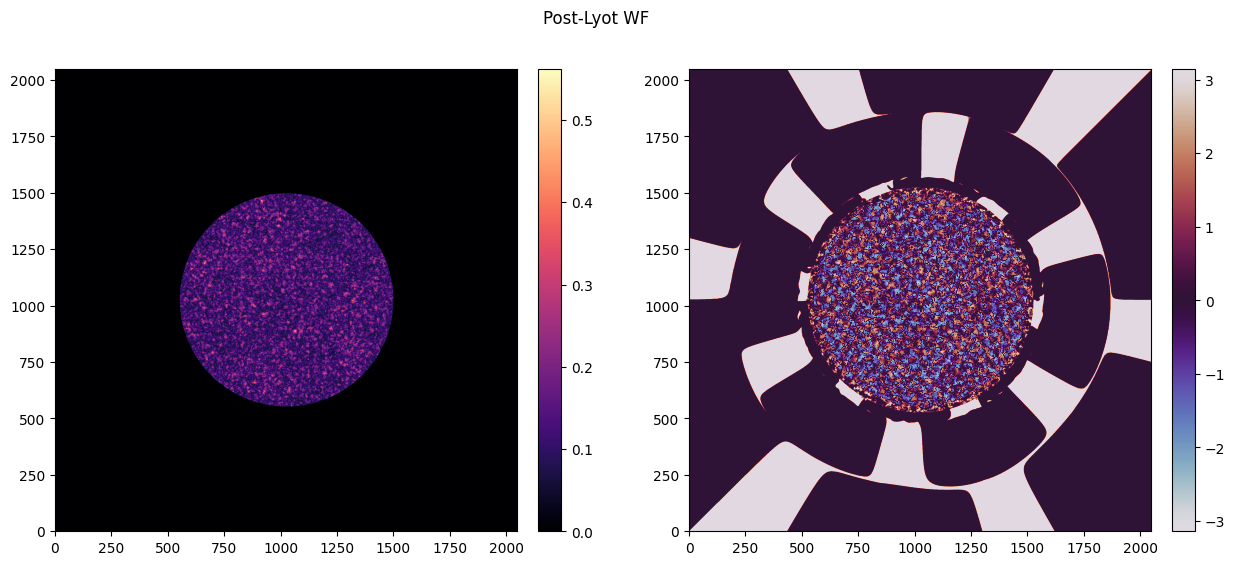

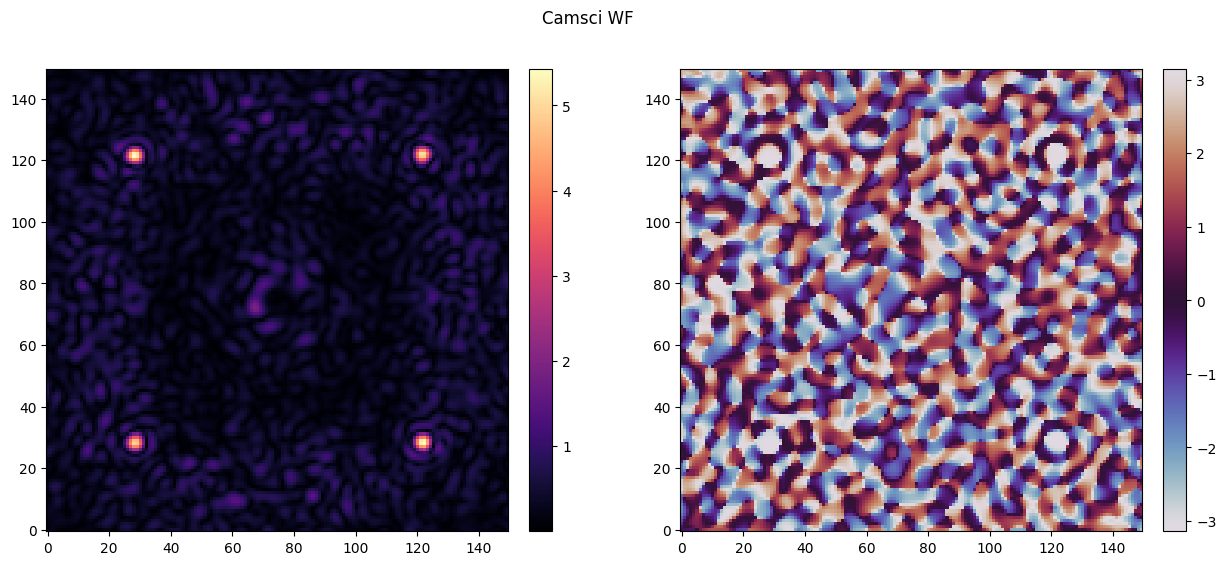

In [6]:
for E, title in zip(Efields, titles):
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.imshow(xp.abs(E).get(), cmap='magma')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(122)
    plt.imshow(xp.angle(E).get(), cmap='twilight')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.suptitle(title)